# Introduction

Proteins, as one of the basic buildling blocks of human cells, serve crucial roles in cell operations. Protein subcellular localizations, which is the location of proteins in specific cell organelles and structures, can provide key information for human protein study.

In the previous *Human Protein Atlas Image Classification* project in this series, a Computer Vision approach of predicting the protein subcellular localizations is demonstrated using CNNs. However, in cases where the structural data of the amino acid chain is available, the sequential data can be studied for subcellular localization classification tasks using Recurrent Neural Networks (RNN), such as models that utilize LSTMs.

In the following, a CNN-LSTM model is designed and implemented in Theano. The model consists of both convolutional layers and a pair of bidirectional LSTM layers as the RNN component. After 100 epochs of training, the model achieves 80% - 85% of accuracy. Given the classes of the dataset are considerably balanced, this accuracy has shown the high capability of RNN models to perform single-label classification tasks on protein cellular localizations, given its sequential representation.

The model is trained using the extensive *MultiLoc* dataset. The dataset is used in a wide range of academic studies and researches. It extracts protein sequences from a great variety of fungus, plants and animals, and was released in 2003-2004 from the SWISS_PROT database. Each protein sequence in the dataset is single-class labelled with one eukaryotic subcellular localization. There are 10 classes in total, which are Nucleus, Cytoplasm, Extracellular, Mitochondrion, Cell membrane, ER, Chloroplast, Golgi apparatus, Lysosome and Vacuole. The dataset has been used to develop the *MultiLoc* prootein subcellular localization prediction tool, specified in the research *MultiLoc: prediction of protein subcellular localization using N-terminal targeting sequences, sequence motifs and amino acid composition* ([DOI:10.1093/bioinformatics/btl002](https://academic.oup.com/bioinformatics/article/22/10/1158/236546)) conducted by Annette Höglund and Oliver Kohlbacher.

# Metric Definition

In [1]:
import os
import sys
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"

import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as T
import lasagne

%matplotlib inline

Unlike Tensorflow or Scikit Learn, for Theano, there is no built-in metrics or confusion matrices. Thus, for a single-label classification task, a customized confusion matrix would have to be implemented manually as a metric evaluation for model training.

In [2]:
class CM:
    def __init__(self, num_classes):
        self.n_classes = num_classes
        self.class_names = list(map(str, range(num_classes))) # Class names are '0', ... , '9'
        self.max_len = 1
        self.mat = np.zeros((num_classes,num_classes), dtype='int') # a square matrix.
    
    # Getter
    def getMatrix(self):
        return self.mat
    
    # add a batch of outputs and predictions to the matrix.
    def addBatch(self, targets, preds):
        targets = targets.flatten()
        preds = preds.flatten()
        for i in range(len(targets)):
            self.mat[targets[i], preds[i]] += 1
            
    # Get true/false positive/negatives from the matrix.
    def get_errors(self):
        tp = np.asarray(np.diag(self.mat).flatten(),dtype='float')
        fn = np.asarray(np.sum(self.mat, axis=1).flatten(),dtype='float') - tp
        fp = np.asarray(np.sum(self.mat, axis=0).flatten(),dtype='float') - tp
        tn = np.asarray(np.sum(self.mat)*np.ones(self.n_classes).flatten(), dtype='float') - tp - fn - fp
        return tp, fn, fp, tn

    # Gets the accuracy metric from the matrix
    # Calculated using true positives / total size
    def accuracy(self):
        tp, _, _, _ = self.get_errors()
        return np.sum(tp) / np.sum(self.mat)

# Model Definition

First, a set of training hyperparameters are pre-defined.

Afterwards, a set of Theano tensors are first set up as the input, the target(output), and the mask of the model that is to be defined later.

In [3]:
BATCH_SIZE = 128
SEQ_LEN = 400
FEATURES = 20
HIDDEN_LAYERS = 15
CLASSES = 10
LEARNING_RATE = 0.0025
FILTERS = 10
DROP_RATE = 0.5

inputTensor = T.ftensor3('inputs') # 3D int32 vector
outputTensor = T.ivector('output') # 1D int32 vector
maskTensor = T.fmatrix('masks') # 2D float32 matrix for masking/padding

Now, define the model. The data is first passed through an input layer. For the CNN part, the reversed data is passed through two 1D convolutional layers, with their results concatenated, then passed through another 1D convolutional layer. Note that the first pair of convolutional layers have filter size set to be 3 and 5 respectively to learn both detailed and more general features. Non-linearities are all set to be Rectified Linear Unit (ReLU). Finally, the data dimension is reversed back.

For the RNN component, a pair of bidirectional LSTMs are setup and concatenated. The activation functions of both layers are set to be tanh.

The resulting data is finally passed through a dense layer for feedforward learning. The final activation function for the output layer is set to be softmax.

In [4]:
# CNN part
inputLayer = lasagne.layers.InputLayer(shape=(BATCH_SIZE, None, FEATURES),
                                      input_var=inputTensor,
                                      name="inputLayer")
shuffleLayer = lasagne.layers.DimshuffleLayer(inputLayer, (0, 2, 1)) # reverse the last two dim

convLayer1 = lasagne.layers.Conv1DLayer(shuffleLayer,
                                       num_filters=FILTERS,
                                       pad='same', stride=1,
                                       filter_size=3,
                                       nonlinearity=lasagne.nonlinearities.rectify) #RELU
convLayer2 = lasagne.layers.Conv1DLayer(shuffleLayer,
                                       num_filters=FILTERS,
                                       pad='same', stride=1,
                                       filter_size=5,       # inc filter size, larger feature.
                                       nonlinearity=lasagne.nonlinearities.rectify) #RELU
concatedConvLayer = lasagne.layers.ConcatLayer([convLayer1, convLayer2])

fullConvLayer = lasagne.layers.Conv1DLayer(concatedConvLayer, 
                                          num_filters=FILTERS*2,
                                          pad='same', stride=1,
                                          filter_size=3,
                                          nonlinearity=lasagne.nonlinearities.rectify)
fullConvLayer = lasagne.layers.DimshuffleLayer(fullConvLayer, (0, 2, 1))

# Bidirectional RNN part
maskLayer = lasagne.layers.InputLayer(shape=(BATCH_SIZE, None), 
                                      input_var=maskTensor,
                                     name="maskLayer")

forwardLayer = lasagne.layers.LSTMLayer(fullConvLayer, 
                                        num_units=HIDDEN_LAYERS,
                                        name='LSTMForward',
                                        mask_input=maskLayer,
                                        only_return_final=True,
                                        nonlinearity=lasagne.nonlinearities.tanh)
backwardLayer = lasagne.layers.LSTMLayer(fullConvLayer, 
                                        num_units=HIDDEN_LAYERS,
                                        name='LSTMBackward',
                                        mask_input=maskLayer,
                                        only_return_final=True,
                                        backwards=True,
                                        nonlinearity=lasagne.nonlinearities.tanh)
concatedLSTM = lasagne.layers.ConcatLayer([forwardLayer, backwardLayer])


# Densely Connected and output
denseLayer = lasagne.layers.DenseLayer(concatedLSTM,
                                      num_units=HIDDEN_LAYERS*2,
                                      name="Dense Layer",
                                      nonlinearity=lasagne.nonlinearities.rectify)
fullNN = lasagne.layers.DenseLayer(lasagne.layers.dropout(denseLayer, p=DROP_RATE),
                                   num_units=CLASSES,
                                   name="Softmax",
                                   nonlinearity=lasagne.nonlinearities.softmax)

# fullNN is the final model.

Next, define the loss, gradient, and backpropagation process of the model. For this single-label classification task, the loss is defined as categorical crossentropy. The gradients are normalized before the backpropagation process using the Adam optimizer. 

In [5]:
trainPrediction = lasagne.layers.get_output(fullNN,
                                      inputs={
                                          inputLayer: inputTensor,
                                          maskLayer: maskTensor
                                      },
                                      deterministic=False)

# For single-label classification: 
trainLoss = T.nnet.categorical_crossentropy(trainPrediction, outputTensor)
trainLoss = T.mean(trainLoss)

# get gradients and perform total norm constraint normalization
params = lasagne.layers.get_all_params([fullNN], trainable=True)
gradients = lasagne.updates.total_norm_constraint(T.grad(trainLoss, params), 3)

# Update weights
adamUpdate = lasagne.updates.adam(gradients, params=params, learning_rate=LEARNING_RATE)

In [6]:
valPrediction = lasagne.layers.get_output(fullNN,
                                          inputs={
                                              inputLayer: inputTensor,
                                              maskLayer: maskTensor
                                          },
                                          deterministic=True)

# For single-label classification: 
valLoss = lasagne.objectives.categorical_crossentropy(valPrediction, outputTensor)
valLoss = T.mean(valLoss)

Finally, the model-training function and the model-validating function are defined using the previously-defined loss and prediction, and the Adam-optimized backpropagation function.

In [7]:
trainModel = theano.function([inputTensor, outputTensor, maskTensor], 
                             [trainLoss, trainPrediction],
                            updates=adamUpdate)
validateModel = theano.function([inputTensor, outputTensor, maskTensor],
                               [valLoss, valPrediction])

# Training

First, read in the data.

In [8]:
train = np.load('Dataset/train.npz')
(X_train, y_train, mask_train) = (train['X_train'], train['y_train'], train['mask_train'])

test = np.load('Dataset/test.npz')
(X_test, y_test, mask_test) = (test['X_test'], test['y_test'], test['mask_test'])

print(X_train.shape, X_test.shape)

(4763, 1000, 20) (1195, 1000, 20)


Before training, a mechanism to iterate through the data in batches must be defined. The three arrays of inputs, outputs and masks are first sorted by length, then a list of the indices to mark each batch is generated depending on the length, and shuffled. Afterwards, the three arrays are split into batches individually, and are cropped to the maximum length of the three batches in each group. Eventually, the input, output and mask batch are generated, shuffled, and returned as a group.

In [9]:
import random

def iterBatch(inputs, outputs, masks, batchsize):
    assert len(inputs) == len(outputs)
    
    # Calculate and sort the sample sequences by length.
    seq_length = np.apply_along_axis(np.bincount, 1, masks.astype(np.int32))[:, -1]
    indices = np.argsort(seq_length)
    
    # Divide the input list of sequences into batches. The remainder is set to be the last sequence.
    f_idx = len(inputs) % batchsize
    idx_lst = list(range(0, len(inputs) - batchsize + 1, batchsize))
    last_idx = None
    
    if f_idx != 0:
        last_idx = idx_lst[-1] + batchsize
        idx_lst.append(last_idx)
    
    # Shuffle the batches
    random.shuffle(idx_lst)
    
    
    for idx in idx_lst:
        # Split into batches
        if idx == last_idx:
            randomSample = batchsize - f_idx
            b = np.random.randint(len(inputs), size=randomSample)
            excerpt = np.concatenate((indices[idx:idx + batchsize], b))
        else:
            excerpt = indices[idx:idx + batchsize]
        
        # Crop the batch of each of the three arrays to the maximum length of the three.
        max_prot = np.amax(seq_length[excerpt])
        seqIn = inputs[excerpt][:, :max_prot]
        maskIn = masks[excerpt][:, :max_prot]
        outputIn = outputs[excerpt]
        
        # Shuffle and generate a batch of each array.
        shuffleIndex = np.arange(batchsize)
        np.random.shuffle(shuffleIndex)
        yield seqIn[shuffleIndex], outputIn[shuffleIndex], maskIn[shuffleIndex]

Now, execute the training. Each training batch and validation batch is generated using the *iterBatch* function, then
is trained or validated using *trainModel* or *validateModel* function, respectively. For each batch, the prediction result and error are recorded, and for each epoch, the total loss and accuracy are calculated using the record and the confusion matrix. 

In [14]:
EPOCHS = 100

# lists to record metrics for each epoch.
trainLoss = []
testLoss = []
trainAcc = []
testAcc = []
start = time.time()
testLossMin = float('inf')

# Iteration
for epoch in range(EPOCHS):
    
    # Init training params
    errorSum = 0
    trainBatchSum = 0
    trainConfusionMatrix = CM(CLASSES)
    
    # Generate batches
    for batch in iterBatch(X_train.astype(np.float32),
                           y_train.astype(np.int32),
                           mask_train.astype(np.float32),
                           BATCH_SIZE):
        inputs, outputs, masks = batch
        
        # Train
        err, pred = trainModel(inputs, outputs, masks)
        
        # Record result and update confusion matrix
        errorSum += err
        trainBatchSum += 1  
        pred = np.argmax(pred, axis = -1)
        trainConfusionMatrix.addBatch(outputs, pred)
    
    # Calculate metrics
    epochLoss = errorSum / trainBatchSum
    epochAcc = trainConfusionMatrix.accuracy()
    epochCF = trainConfusionMatrix.getMatrix()
    
    # Init validation params
    testErrorSum = 0
    testBatchSum = 0
    testConfusionMatrix = CM(CLASSES)
    
    # Generate batches
    for batch in iterBatch(X_test.astype(np.float32), 
                           y_test.astype(np.int32),
                           mask_test.astype(np.float32),
                           BATCH_SIZE):
        inputs, outputs, masks = batch
        
        # Validate
        err, pred = validateModel(inputs, outputs, masks)
        
        # Record result and update confusion matrix
        testErrorSum += err
        testBatchSum += 1
        pred = np.argmax(pred, axis=-1)
        testConfusionMatrix.addBatch(outputs, pred)
        
    # Calculate metrics
    epochTestLoss = testErrorSum / testBatchSum
    epochTestAcc = testConfusionMatrix.accuracy()
    epochTestCF = testConfusionMatrix.getMatrix()
    
    # Record metrics
    trainLoss.append(epochLoss)
    testLoss.append(epochTestLoss)
    trainAcc.append(epochAcc)
    testAcc.append(epochTestAcc)
    
    # Save weights in file
    if testLossMin > epochTestLoss:
        testLossMin = epochTestLoss
        np.savez('weights/modelWeights.npz', *lasagne.layers.get_all_param_values(fullNN))
    
    # Side effects
    print("EPOCH {}/{}, timed {:.3f}s".format(epoch+1, EPOCHS, time.time() - start))
    print("\t training loss:\t\t {:.4f}".format(epochLoss))
    print("\t validation loss:\t {:.4f}".format(epochTestLoss))
    print("\t training acc:\t\t {:.4f}".format(epochAcc))
    print("\t validation acc:\t {:.4f}".format(epochTestAcc))

EPOCH 1/100, timed 29.643s
	 training loss:		 1.5199
	 validation loss:	 1.3479
	 training acc:		 0.4317
	 validation acc:	 0.4766
EPOCH 2/100, timed 56.765s
	 training loss:		 1.3973
	 validation loss:	 1.2176
	 training acc:		 0.4725
	 validation acc:	 0.5547
EPOCH 3/100, timed 82.781s
	 training loss:		 1.3415
	 validation loss:	 1.1775
	 training acc:		 0.5144
	 validation acc:	 0.5555
EPOCH 4/100, timed 108.255s
	 training loss:		 1.2763
	 validation loss:	 1.1733
	 training acc:		 0.5292
	 validation acc:	 0.6008
EPOCH 5/100, timed 132.654s
	 training loss:		 1.2291
	 validation loss:	 1.0558
	 training acc:		 0.5656
	 validation acc:	 0.5969
EPOCH 6/100, timed 157.582s
	 training loss:		 1.1456
	 validation loss:	 0.9972
	 training acc:		 0.6009
	 validation acc:	 0.6344
EPOCH 7/100, timed 181.848s
	 training loss:		 1.1110
	 validation loss:	 0.9578
	 training acc:		 0.6205
	 validation acc:	 0.6586
EPOCH 8/100, timed 207.356s
	 training loss:		 1.0970
	 validation loss:	 0.913

EPOCH 63/100, timed 1529.607s
	 training loss:		 0.5477
	 validation loss:	 0.5983
	 training acc:		 0.8069
	 validation acc:	 0.8031
EPOCH 64/100, timed 1553.604s
	 training loss:		 0.5467
	 validation loss:	 0.6141
	 training acc:		 0.8135
	 validation acc:	 0.8094
EPOCH 65/100, timed 1577.710s
	 training loss:		 0.5419
	 validation loss:	 0.5677
	 training acc:		 0.7998
	 validation acc:	 0.8102
EPOCH 66/100, timed 1601.014s
	 training loss:		 0.5302
	 validation loss:	 0.5772
	 training acc:		 0.8043
	 validation acc:	 0.8102
EPOCH 67/100, timed 1624.427s
	 training loss:		 0.5449
	 validation loss:	 0.6015
	 training acc:		 0.8030
	 validation acc:	 0.8117
EPOCH 68/100, timed 1648.540s
	 training loss:		 0.5248
	 validation loss:	 0.6192
	 training acc:		 0.8123
	 validation acc:	 0.8070
EPOCH 69/100, timed 1672.401s
	 training loss:		 0.5228
	 validation loss:	 0.6269
	 training acc:		 0.8076
	 validation acc:	 0.7961
EPOCH 70/100, timed 1695.796s
	 training loss:		 0.5247
	 vali

# Evaluation

Using matplotlib, the loss and accuracy trends during training are plotted as follows:

In [15]:
print(testLossMin)

0.5672906875610352


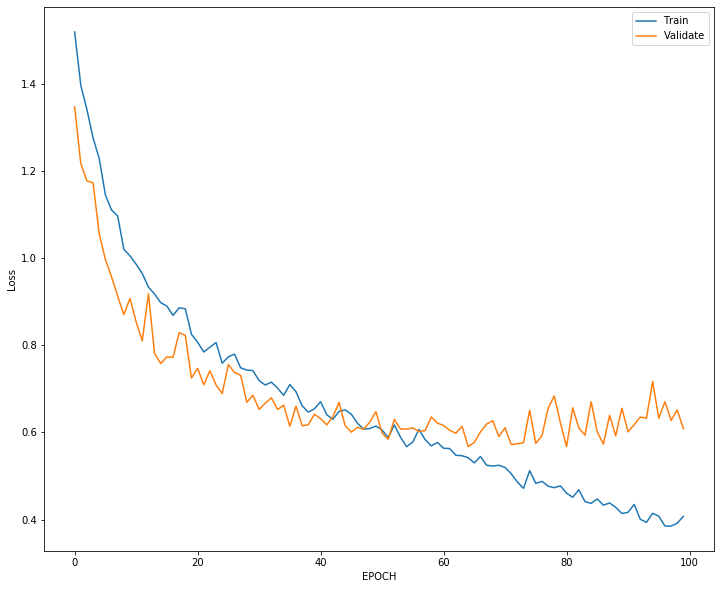

In [16]:
x = range(EPOCHS)
plt.figure(figsize=(12, 10))
plt.plot(x, trainLoss)
plt.plot(x, testLoss)
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend(('Train', 'Validate'))

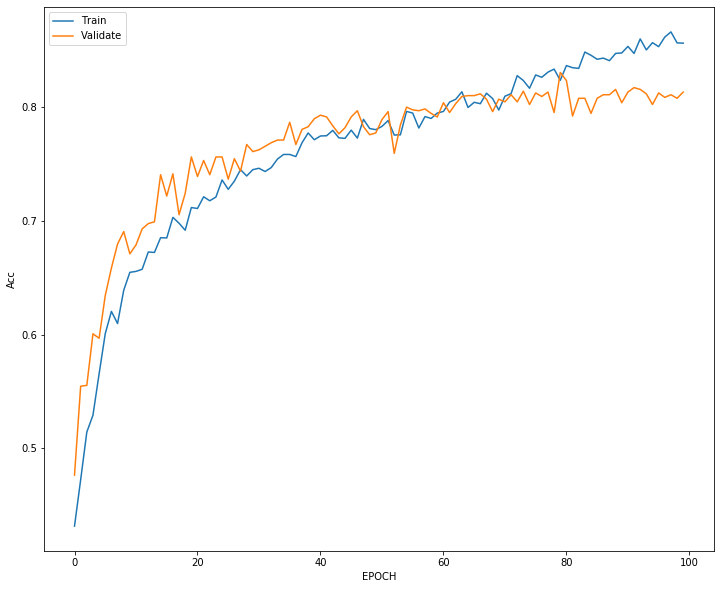

In [17]:
x = range(EPOCHS)
plt.figure(figsize=(12, 10))
plt.plot(x, trainAcc)
plt.plot(x, testAcc)
plt.xlabel('EPOCH')
plt.ylabel('Acc')
plt.legend(('Train', 'Validate'))

Now, display the confusion matrix.

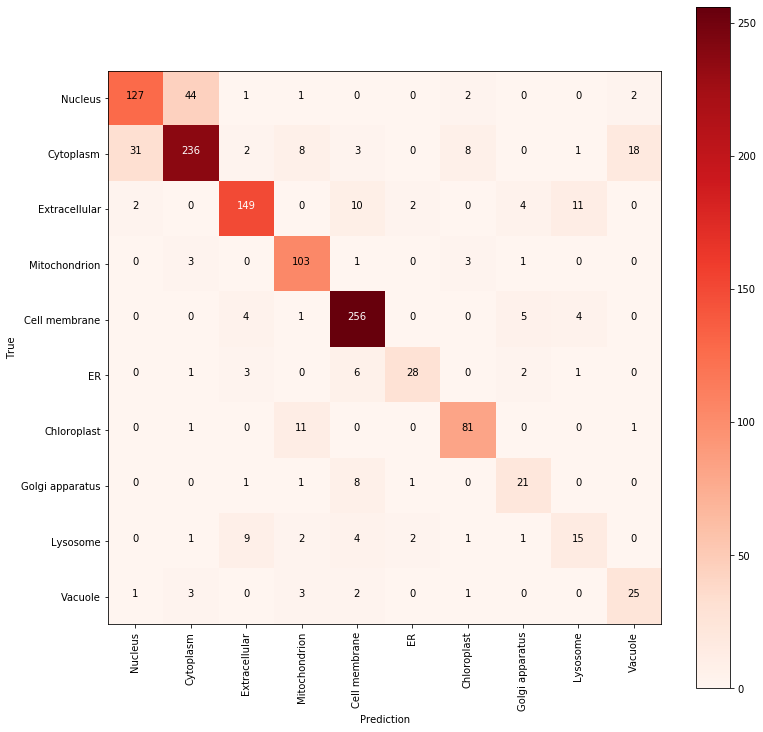

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(epochTestCF, interpolation='nearest', cmap=plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True')
plt.xlabel('Prediction');
ticks = np.arange(CLASSES)
plt.colorbar()
classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']
plt.xticks(ticks, classes, rotation=90)
plt.yticks(ticks, classes)

maxVal = epochTestCF.max() / 2
for i, j in itertools.product(range(epochTestCF.shape[0]), range(epochTestCF.shape[1])):
    plt.text(j, i, epochTestCF[i, j],
             horizontalalignment="center",
             color="white" if epochTestCF[i, j] > maxVal else "black")

It can be observed that in most cases, the predicted label and the true label match. For limitations, the model has a considerable amount of cases mistakening proteins in Nuclues as proteins in Cytoplasm and vica versa. However, in general this model is reliable for protein subcellular localization predictions. The highest accuracy is around 80% - 85%.

# Conclusion

Predicting protein subcellular localizations is a scientific task that is of high importance to protein studies. In this project, a CNN-LSTM model is designed, implemented in Theano, and trained using the *MultiLoc* dataset to perform a single-label classification task on protein subcellular localizations, given the sequential representation of the protein structure. The training result shows that the model eventually achieves an accuracy of approximately 85%. While this metric is far more modest than many of the modern protein subcellular localization prediction tools, it has shown that CNN-LSTM-based deep learning RNN model is a promising approach to perform such tasks, and ideally with more hyperparameter-tuning and training with datasets that are of greater volume, such RNN models can offer considerable scientific value in the field of protein research and studies.

# Acknowledgement

This notebook is adapted from the [instructions](https://github.com/vanessajurtz/lasagne4bio/tree/master/subcellular_localization) given by Jose Juan Almagro Armenteros. His effort and guidance is greatly appreciated.